In [368]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.integrate import solve_ivp
from math import dist
import pandas as pd

In [369]:
global NumSpecies,mu,lambdaa,gamma,delta,D,eta,kappa,Ip,Nm

In [370]:
def MultiSpecies(t,y):
    dydt=np.zeros(NumSpecies*(1+NumSpecies))
    for i in range(NumSpecies):
        if y[i]==0:
            dydt[i]=Ip[i]
            for j in range(NumSpecies):
                dydt[NumSpecies+i*NumSpecies+j]=0
        else:
            ss=1
            sumy_neg=0
            sumy_pos=0
            for j in range(NumSpecies):
                if i!=j:
                    ss=ss*(1+lambdaa[j]*y[NumSpecies+i*NumSpecies+j]/y[i])
                if gamma[j,i]<0:
                    sumy_neg=sumy_neg+gamma[j,i]*y[j]
                if gamma[j,i]>0:
                    sumy_pos=sumy_pos+gamma[j,i]*y[j]
            dydt[i]=mu[i]*y[i]*ss*(1+sumy_neg/Nm[i]+delta[i]*sumy_pos/(1+sumy_pos)/Nm[i])-D*y[i]+Ip[i]
            for j in range(NumSpecies):
                if j==i:
                    dydt[NumSpecies+i*NumSpecies+j]=dydt[i]
                else:
                    ss=1
                    for k in range(NumSpecies):
                        if k!=i and k!=j:
                            ss=ss*(1+lambdaa[k]*y[NumSpecies+i*NumSpecies+k]/y[i])
                    donor=0
                    for k in range(NumSpecies):
                        donor=donor+y[NumSpecies+k*NumSpecies+j]
                    dydt[NumSpecies+i*NumSpecies+j]=mu[i]*y[NumSpecies+i*NumSpecies+j]*ss*(1+lambdaa[j])*(1+sumy_neg/Nm[i]+delta[i]*sumy_pos/(1+sumy_pos)/Nm[i])+eta*(y[i]-y[NumSpecies+i*NumSpecies+j])*donor-(kappa+D)*y[NumSpecies+i*NumSpecies+j]
    return dydt

In [371]:
NumSpecies=20
mu0=0.5
etas=[0,0.2]
repeat=100
Ip=0*np.ones(NumSpecies)
delta=0.2*np.ones(NumSpecies)
kappa=0.005
D=0.2
thresh=0.05

In [372]:
timespan=np.arange(0,3000.1,.1)
Abun=np.zeros((len(etas),repeat,NumSpecies))

lambdaa=-0.4+0.8*np.random.rand(NumSpecies)
mu=np.multiply(mu0,1+lambdaa)
gamma=np.zeros((NumSpecies,NumSpecies))
NumNiche=7#min(int(NumSpecies*np.random.rand()+2),int(NumSpecies/2))
II=np.zeros(NumNiche)
for i in np.arange(1,NumNiche,1):
    II[i]=np.random.rand()
II=np.sort(II)
Tape=np.zeros(NumSpecies)
for i in range(NumSpecies):
    temp=np.random.rand()
    for j in range(len(II)):
        if temp>=II[j]:
            Tape[i]=j

NN=np.random.rand(NumSpecies)
Nm=np.zeros(NumSpecies)
for i in range(NumSpecies):
    Nm[i]=NN[int(Tape[i])]
for i in range(NumSpecies):
    #for j in np.arange(i,NumSpecies,1):
    for j in range(NumSpecies):
        if i==j:
            gamma[i,j]=-1
        else:
            if Tape[i]==Tape[j]:
                gamma[i,j]=-1.05

for i in range(len(etas)):
    eta=etas[i]
    for hjk in range(repeat):
        print(i*repeat+hjk)
        initial=np.zeros(NumSpecies**2+NumSpecies)
        for j in range(NumSpecies):
            initial[j]=np.random.rand()#*2/NumSpecies
            initial[NumSpecies+j*NumSpecies+j]=initial[j]          
        sol=solve_ivp(MultiSpecies,[0,max(timespan)],initial,method='RK45',t_eval=timespan)
        y=np.transpose(sol.y)
        temp=y[-1,range(NumSpecies)]
        Abun[i,hjk,:]=temp

0
1


KeyboardInterrupt: 

In [ ]:
thresh=0.02
AbunTot=np.zeros((len(etas),repeat,NumSpecies))
for i in range(len(etas)):
    for j in range(repeat):
        for k in range(NumSpecies):
            AbunTot[i,j,k]=np.divide(Abun[i,j,k],np.sum(Abun[i,j,:]))
Index=np.zeros((len(etas),repeat))
Index[0,0]=1
Index[1,0]=1
for i in range(len(etas)):
    for j in np.arange(1,repeat,1):
        tempj=Abun[i,j,:]
        pin=0
        for k in range(j):
            tempk=Abun[i,k,:]
            tttt=tempj-tempk
            dis=np.sqrt(sum(np.multiply(tttt,tttt)))
            if dis<thresh:
                Index[i,j]=Index[i,k]
                pin=1
        if pin==0:
            Index[i,j]=max(Index[i,:])+1
    

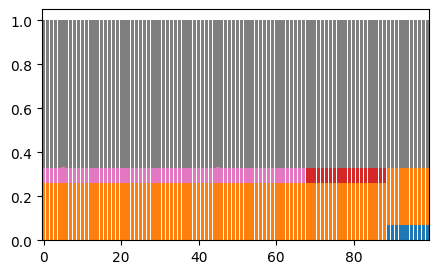

In [ ]:
plt.figure(figsize=(5,3))
temp0=AbunTot[0,:,:]
II0=np.argsort(Index[0,:])
temp1=temp0[II0,:]
for i in range(NumSpecies):
    if i==0:
        plt.bar(np.arange(0,repeat,1),temp1[:,i])
    if i>0:
        plt.bar(np.arange(0,repeat,1),temp1[:,i],bottom=np.sum(temp1[:,range(i)],axis=1))
plt.xlim(-0.5,repeat-0.5)
plt.savefig('NicheExample_NoHGT.pdf')
plt.show()

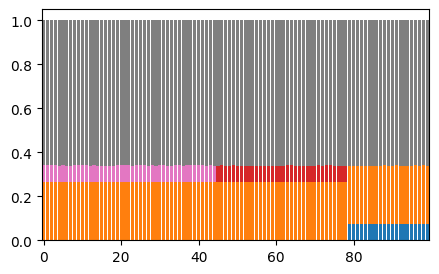

In [ ]:
plt.figure(figsize=(5,3))
temp2=AbunTot[1,:,:]
II1=np.argsort(Index[1,:])
temp3=temp2[II1,:]
for i in range(NumSpecies):
    if i==0:
        plt.bar(np.arange(0,repeat,1),temp3[:,i])
    if i>0:
        plt.bar(np.arange(0,repeat,1),temp3[:,i],bottom=np.sum(temp3[:,range(i)],axis=1))
plt.xlim(-0.5,repeat-0.5)
plt.savefig('NicheExample_HGT.pdf')
plt.show()
import pandas as pd
df1=pd.DataFrame(AbunTot[0,:,:])
df1.to_csv("AbundanceWithoutHGT.csv")
df2=pd.DataFrame(AbunTot[1,:,:])
df2.to_csv("AbundanceWithHGT.csv")

In [ ]:
c=np.zeros((2,2))
print(c)
a=c[0,:]
print(a)
a[1]=1
print(a)
print(c)


[[0. 0.]
 [0. 0.]]
[0. 0.]
[0. 1.]
[[0. 1.]
 [0. 0.]]


In [ ]:
print(1-D/mu[1])

0.6531781983750636
